<a href="https://colab.research.google.com/github/Robinjean/Project_Covid19_Fake_news_detection_using_RNN_LSTM_GRU_transformers/blob/main/LSTMProject_Covid19_fake_news_detection_using_LSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wordcloud

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

#Load datasets

In [3]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset files
train_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/Constraint_English_Train - Sheet1.csv'
val_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/Constraint_English_Val - Sheet1.csv'
test_path = '/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/english_test_with_labels - Sheet1.csv'

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

Mounted at /content/drive


In [4]:
df = pd.concat([train_df,val_df, test_df])

In [5]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
# Map labels to numerical values
label_mapping = {'real': 1, 'fake': 0}
df['label'] = df['label'].map(label_mapping)

In [7]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10700 non-null  int64 
 1   tweet   10700 non-null  object
 2   label   10700 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 334.4+ KB


In [9]:
df['label'].value_counts() #===> the data is imbalaced

label
1    5600
0    5100
Name: count, dtype: int64

#Data Preprocessing

Lowercasing

In [10]:
df['lower_text'] = df['tweet'].str.lower()
df['lower_text']

0       the cdc currently reports 99031 deaths. in gen...
1       states reported 1121 deaths a small rise from ...
2       politically correct woman (almost) uses pandem...
3       #indiafightscorona: we have 1524 #covid testin...
4       populous states can generate large case counts...
                              ...                        
2135    #coronavirusupdates: state-wise details of tot...
2136    tonight 12(midnight) onwards disaster manageme...
2137    296 new cases of #covid19nigeria; plateau-85 e...
2138    rt @cdcemergency: #dyk? @cdcgov’s one-stop sho...
2139    more than half of pregnant women recently admi...
Name: lower_text, Length: 10700, dtype: object

 Removing URLs and special characters

In [11]:
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'http\S+', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'\S*@\S*\s?', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
df['text'] = df['lower_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [12]:
df['text']

0       the cdc currently reports 99031 deaths  in gen...
1       states reported 1121 deaths a small rise from ...
2       politically correct woman  almost  uses pandem...
3        indiafightscorona  we have 1524  covid testin...
4       populous states can generate large case counts...
                              ...                        
2135     coronavirusupdates  state wise details of tot...
2136    tonight 12 midnight  onwards disaster manageme...
2137    296 new cases of  covid19nigeria  plateau 85 e...
2138    rt  cdcemergency   dyk   cdcgov s one stop sho...
2139    more than half of pregnant women recently admi...
Name: text, Length: 10700, dtype: object

Removing stopwords

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = stopwords.words('english')

In [15]:
extra = extra = ['https','t','co']

Adding the elements of extra to the stopwords

In [16]:
for c in extra:
  stop_words.append(c)

In [17]:
df['text_clean'] = df['text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

In [18]:
df['text_clean']

0       cdc currently reports 99031 deaths general dis...
1       states reported 1121 deaths small rise last tu...
2       politically correct woman almost uses pandemic...
3       indiafightscorona 1524 covid testing laborator...
4       populous states generate large case counts loo...
                              ...                        
2135    coronavirusupdates state wise details total co...
2136    tonight 12 midnight onwards disaster managemen...
2137    296 new cases covid19nigeria plateau 85 enugu ...
2138    rt cdcemergency dyk cdcgov one stop shop covid...
2139    half pregnant women recently admitted uk hospi...
Name: text_clean, Length: 10700, dtype: object

Stemming

In [19]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
porter = PorterStemmer()

# Define a function for stemming
def stem_text(text):
    # Tokenize the text
    words = text.split()
    # Stem each word using Porter Stemmer
    stemmed_words = [porter.stem(word) for word in words]
    # Join the stemmed words back into a single string
    stemmed_text = " ".join(stemmed_words)
    return stemmed_text

In [20]:
# Apply stemming to the 'text_clean' column
df['text_clean'] = df['text_clean'].apply(stem_text)

# Display the preprocessed data
df['text_clean']

0       cdc current report 99031 death gener discrep d...
1       state report 1121 death small rise last tuesda...
2       polit correct woman almost use pandem excus re...
3       indiafightscorona 1524 covid test laboratori i...
4       popul state gener larg case count look new cas...
                              ...                        
2135    coronavirusupd state wise detail total confirm...
2136    tonight 12 midnight onward disast manag act im...
2137    296 new case covid19nigeria plateau 85 enugu 4...
2138    rt cdcemerg dyk cdcgov one stop shop covid19 r...
2139    half pregnant women recent admit uk hospit cov...
Name: text_clean, Length: 10700, dtype: object

Lemmatization

In [21]:
# import nltk
# from nltk.stem import WordNetLemmatizer

In [22]:
# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

In [23]:
# # Function to perform lemmatization on text
# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text)
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     return ' '.join(lemmatized_tokens)

In [24]:
# # Apply lemmatization to the 'text' column
# df['text_clean'] = df['text_clean'].apply(lambda x: lemmatize_text(x))

In [25]:
# df['text_clean']

#Exploratory Data Analysis

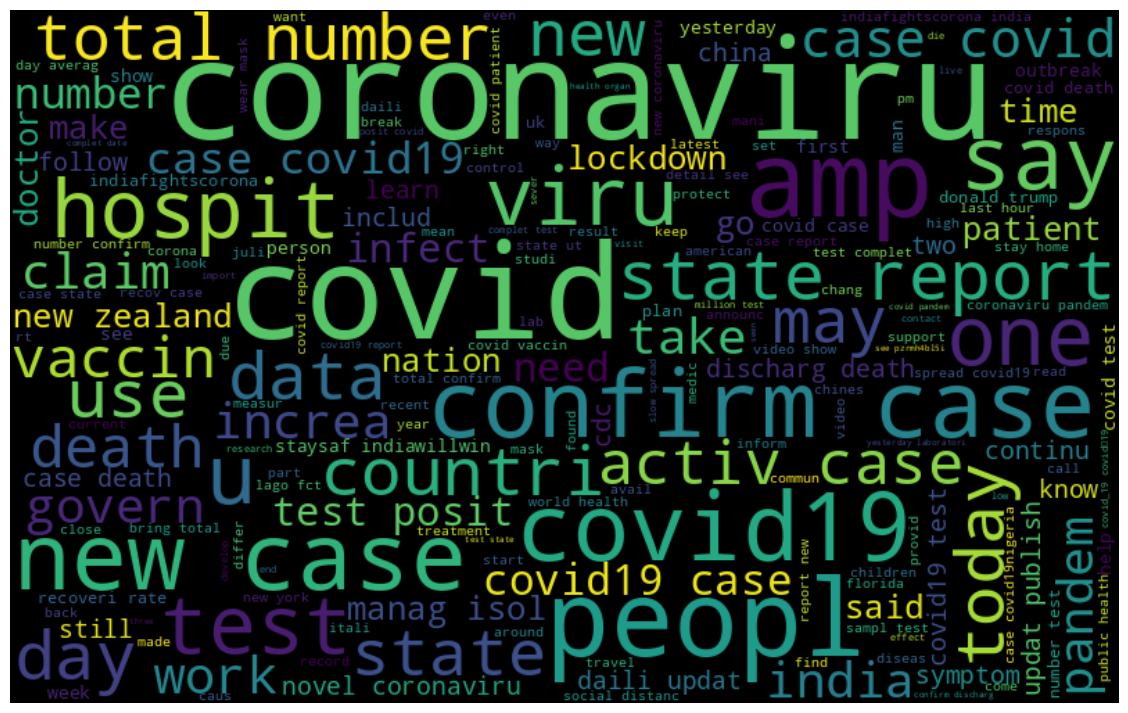

In [26]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in df['text_clean']])


wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size =100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

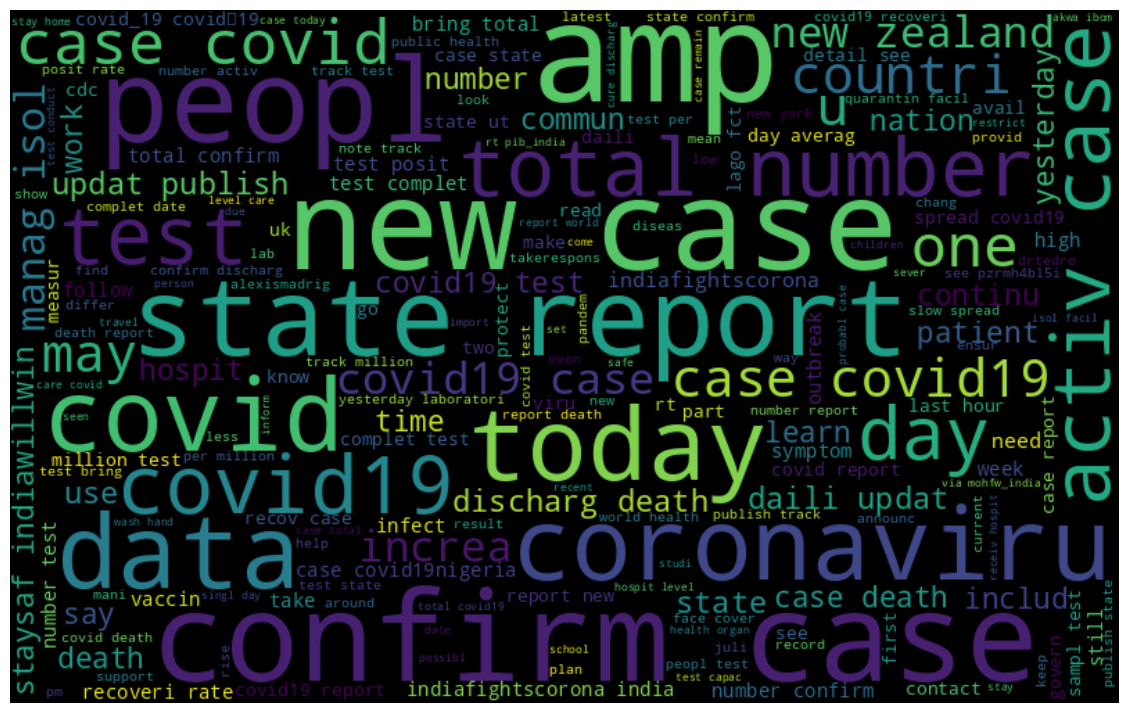

In [27]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['text_clean'][df['label']==1]])

wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size =100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

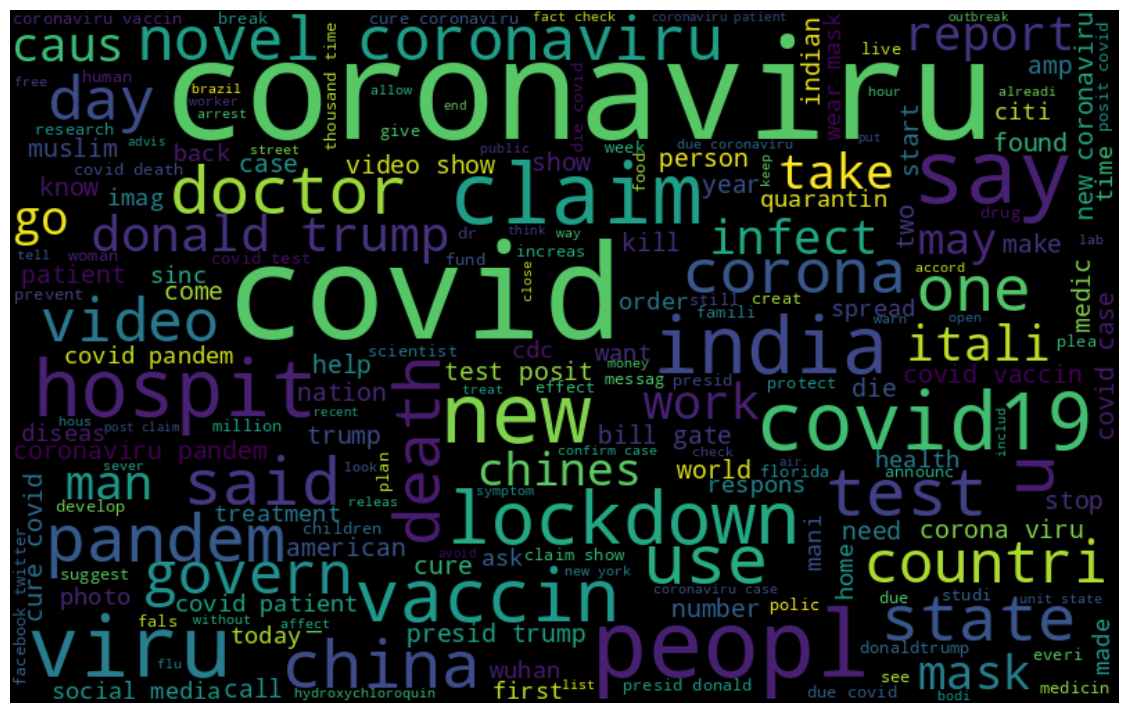

In [28]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df['text_clean'][df['label']==0]])

wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size =100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

#Create word Embeddings

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [30]:
#tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_clean'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

20916

In [31]:
#padding data
sequences = tokenizer.texts_to_sequences(df['text_clean'])

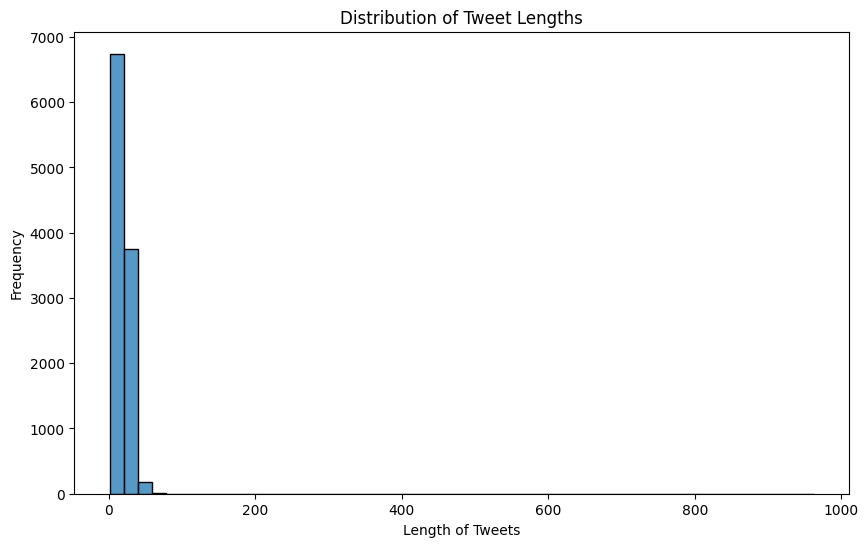

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot([len(x) for x in sequences], bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

In [33]:
max_seq_length = 150
padded_seq = pad_sequences(sequences, maxlen =  max_seq_length, padding = 'post', truncating = 'post')

In [34]:
#create embedding index
embedding_index = {}
with open('/content/drive/My Drive/AMMI_FINAL_RESEARCH_PROJECT/Covid_fake_news/glove.6B.100d.txt', encoding = 'utf_8') as f:
    for line in f:
        values = line.split()
        #print(values)
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embedding_index[word] = coefs
#         print(len(coefs))
#         break

In [35]:
print(len(coefs))

100


In [36]:
#create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    emb_vector = embedding_index.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector

In [37]:
df['label'].value_counts()

label
1    5600
0    5100
Name: count, dtype: int64

In [38]:
embedding_matrix[2]

array([ 0.41051999,  0.058649  ,  0.28514999, -0.099504  ,  0.076813  ,
        0.15387   ,  0.36206001, -0.10112   ,  0.093865  , -0.23309   ,
       -0.13663   ,  0.54576999,  0.0138    ,  0.38415   , -0.39695001,
        0.16227999,  0.099602  ,  0.24988   , -0.33658999,  0.039019  ,
        0.33904999, -0.66241002,  0.37472001,  0.21630999,  0.16886   ,
        0.18165   ,  0.55425   , -0.61009997, -0.85227001,  0.36984   ,
        0.68910003,  0.45315999,  0.082091  ,  0.10839   , -0.24239001,
        0.15888   ,  0.11656   , -0.060652  ,  0.57617998, -0.30419999,
       -0.65261   , -0.38062999,  0.58332002, -1.05040002, -0.095388  ,
        0.014547  ,  0.59942001, -0.55361003,  0.17132001, -0.69450998,
        0.99215001, -0.39131001,  0.31876001,  1.15079999, -0.57279003,
       -1.81480002, -0.39403999, -0.5783    ,  1.92260003,  0.59717   ,
       -0.76435   ,  0.59465998,  0.28298   , -0.25468999,  1.4569    ,
       -0.41196001,  0.43957001,  0.74744999, -0.67474002,  0.43

In [39]:
padded_seq[1]

array([   8,    9, 7251,   10,  722,  204,   58,  986, 2413,    8,    9,
       5149,   10, 7252,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

#Input Split

Here, our dataset is imbalanced, we can use techniques like oversampling the minority class or undersampling the majority class. For simplicity, let's use the SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class.

In [40]:
from imblearn.over_sampling import SMOTE   #Handling Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(padded_seq, df['label'])

Input split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42, stratify=y_res)

In [42]:
x_train

array([[  12,  107, 1448, ...,    0,    0,    0],
       [ 113,    1,    3, ...,    0,    0,    0],
       [ 589,   43,    7, ...,    0,    0,    0],
       ...,
       [  64,   34,  338, ...,    0,    0,    0],
       [2353,    7,    2, ...,    0,    0,    0],
       [ 260, 1100, 3580, ...,    0,    0,    0]], dtype=int32)

#Model Training

In [43]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Embedding, BatchNormalization  #add a 'Bidirectional' LSTM layer and another dense layer for better performance.
from keras import Sequential

# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
#     Bidirectional(LSTM(256, return_sequences=True)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Bidirectional(LSTM(128)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(1, activation='sigmoid')
# ])

In [44]:
model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),  # Reduced units
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout
    Bidirectional(LSTM(64)),  # Reduced units
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout
    Dense(64, activation='relu'),  # Added dense layer
    Dense(1, activation='sigmoid')
])

In [45]:
model.compile(loss ='binary_crossentropy', optimizer ='adam', metrics ='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          2091700   
                                                                 
 bidirectional (Bidirection  (None, 150, 256)          234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 150, 256)          1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 150, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                        

Use class weights to handle the imbalance in the dataset.

In [46]:
#Here, our dataset is imbalanced, we can
#use class weights to penalize the model more for errors in the minority class

from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to dictionary format
class_weights_dict = dict(enumerate(class_weights))

In [47]:
#train the model
history = model.fit(x_train,y_train, epochs = 20, batch_size =256,validation_data = (x_test, y_test), class_weight=class_weights_dict)

Epoch 1/20
35/35 [==============================] - 16s 106ms/step - loss: 0.5699 - accuracy: 0.7148 - val_loss: 0.5735 - val_accuracy: 0.7732
Epoch 2/20
35/35 [==============================] - 2s 67ms/step - loss: 0.4137 - accuracy: 0.8196 - val_loss: 0.4925 - val_accuracy: 0.7777
Epoch 3/20
35/35 [==============================] - 2s 64ms/step - loss: 0.3730 - accuracy: 0.8371 - val_loss: 0.4147 - val_accuracy: 0.8464
Epoch 4/20
35/35 [==============================] - 2s 63ms/step - loss: 0.3478 - accuracy: 0.8575 - val_loss: 0.3855 - val_accuracy: 0.8589
Epoch 5/20
35/35 [==============================] - 2s 63ms/step - loss: 0.3363 - accuracy: 0.8577 - val_loss: 0.4376 - val_accuracy: 0.7746
Epoch 6/20
35/35 [==============================] - 2s 63ms/step - loss: 0.3049 - accuracy: 0.8735 - val_loss: 0.3062 - val_accuracy: 0.8741
Epoch 7/20
35/35 [==============================] - 2s 63ms/step - loss: 0.2928 - accuracy: 0.8785 - val_loss: 0.2987 - val_accuracy: 0.8670
Epoch 8/20


Evaluate the model

In [48]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = (model.predict(x_test) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred))

70/70 [==============================] - 3s 14ms/step
Test Accuracy: 88.44%
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1120
           1       0.85      0.94      0.89      1120

    accuracy                           0.88      2240
   macro avg       0.89      0.88      0.88      2240
weighted avg       0.89      0.88      0.88      2240



#Visualizing Training and Validation Accuracy

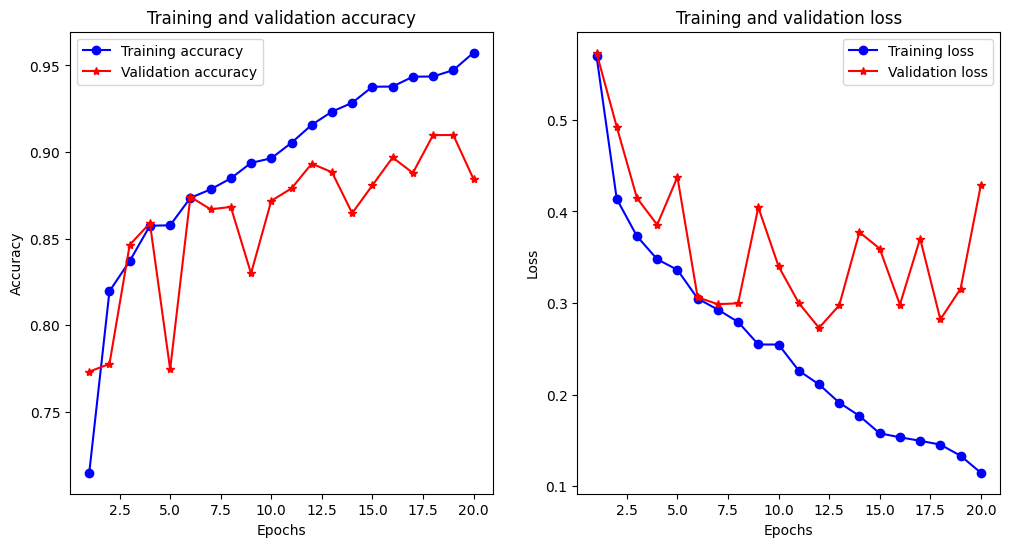

In [51]:
import matplotlib.pyplot as plt

# history is the History object returned by model.fit()
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()